In [1]:
import numpy as np

import pandas as pd

import random

from tqdm import tqdm

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.tri as mtri

from scipy.spatial import Delaunay

from sklearn.metrics import root_mean_squared_error

mpl.rcParams['font.family'] = 'serif'

# 3D N-stream Monte Carlo Simulation with Polyhedra clouds

#### Table of contents 
[1. Cube](#Cube)  
[2. Sphere](#Sphere)  
[3. Pyramid from top](#Pyramid-from-top)  
[3. Pyramid from bottom](#Pyramid-from-top) 

Create clouds of 3 different shapes: cube, sphere, and pyramid  
run 3d montecarlo simulation where 4 things can happen  
1. Reflect - if photon is moving upward when it exits the cloud
2. Transmit - if photon is moving downward when it exits the cloud
3. Absorb 
4. Side exit - if photon is moving orthogonal to top/bottom (unlikely)

In [2]:
# stolen from https://github.com/Edenhofer/monte-carlo-radiative-transfer/blob/master/henyey_#20825estein.py
def rand_mu(n=1, g=0.85):
    r = np.random.rand(n)
    return ((r * ((1 + g**2 - 2*g)**(-1/2) - (1 + g**2 + 2*g)**(-1/2)) + (1 + g**2 + 2*g)**(-1/2))**-2 - 1 - g**2) / (-2 * g)


def henyey(g, mu):
    return (1 - np.power(g, 2)) / np.power(1 + np.power(g, 2) - 2 * g * mu, 3/2)

In [14]:
g = 0.85 # from class
prob_back = (1-g)*0.5 # probability backscatter (low prob)
prob_fwd = (1+g)*0.5 # probability forward scatter (high prob)
omega = 0.99  # single-scattering albedo (0.99 = 1% chance of absorption)
num_sims = 500  
optical_depth = 10  # optical depth for each side of the cube

# the below make the sphere and pyramid the same volume as the cube, based on the optical depth of cube
radius_sphere = optical_depth/((4/3*np.pi)**(1/3))
base_height_pyramid = (3*optical_depth**3)**(1/3) # height and base side lengths (equivalent for simplicity)

tau_array = [-np.log(1-random.uniform(0, 1)) for i in range(1000000)]

They should all have the same volume  
cube = s^3   
sphere = 4/3piR^3 # so R = 3S/((4pi)^(1/3))  
pyramid = 1/3 base_area*h # base_area = h^2; h = (3s^3)^(1/3)  

In [15]:
print(f"radius of sphere is {radius_sphere}\nbase&height of pyramid is {base_height_pyramid}\n")  
print(f"Volume of cube is {optical_depth**3}\nVolume of sphere is {round(4/3*np.pi*radius_sphere**3,0)}\nVolume of pyramid is {round((1/3)*base_height_pyramid**3, 0)}")

radius of sphere is 6.203504908994001
base&height of pyramid is 14.422495703074082

Volume of cube is 1000
Volume of sphere is 1000.0
Volume of pyramid is 1000.0


In [5]:
# animation function
def animate(i, shape, shape_flipped="no"):
    ax.clear()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'photons: {len(all_photon_paths)} \ng: {g}\nω₀: {omega}', weight="bold")
    
    # draw shape
    if shape.lower() == 'cube':
        # cube with length optical depth in x, y, and z
        for edge in cube_edges:
            ax.plot(*zip(*edge), color='black', alpha=0.3)
            
        ax.set_xlim(0, optical_depth)
        ax.set_ylim(0, optical_depth)
        ax.set_zlim(0, optical_depth)

        ax.xaxis.pane.set_edgecolor('lightgrey')
        ax.yaxis.pane.set_edgecolor('lightgrey')
        ax.zaxis.pane.set_edgecolor('lightgrey')
    elif shape.lower() == 'sphere':
        # radius and center at middle of cube
        center = [radius_sphere, radius_sphere, radius_sphere]
        radius = radius_sphere
        u = np.linspace(0, 2*np.pi, 20)
        v = np.linspace(0, np.pi, 20)
        x = center[0] + radius*np.outer(np.cos(u), np.sin(v))
        y = center[1] + radius*np.outer(np.sin(u), np.sin(v))
        z = center[2] + radius*np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_wireframe(x, y, z, color='black', alpha=0.3, rstride=2, cstride=2)
        
        ax.set_xlim(0, 2*radius)
        ax.set_ylim(0, 2*radius)
        ax.set_zlim(0, 2*radius)
        
        ax.xaxis.pane.set_edgecolor('lightgrey')
        ax.yaxis.pane.set_edgecolor('lightgrey')
        ax.zaxis.pane.set_edgecolor('lightgrey')
    elif shape.lower() == 'pyramid':
        # from https://stackoverflow.com/questions/29311682/finding-if-point-is-in-3d-poly-in-python
        x = np.array([0,0,base_height_pyramid/2,base_height_pyramid,base_height_pyramid]) 
        y = np.array([0,base_height_pyramid,base_height_pyramid/2,0,base_height_pyramid]) 
        z = np.array([0,0,base_height_pyramid,0,0]) 
        if shape_flipped == "yes": # photon coming down on top
            z = base_height_pyramid - z
        
        pyramid = Delaunay(np.array([x,y,z]).T)
        #ax.plot_trisurf(x, y, z, triangles=pyramid.simplices)
        ax.plot_trisurf(x, y, z, triangles=pyramid.simplices, color='none', edgecolor='gray', linewidth=1.0)
        
        ax.set_xlim(0, base_height_pyramid)
        ax.set_ylim(0, base_height_pyramid)
        ax.set_zlim(0, base_height_pyramid)
        
        ax.xaxis.pane.set_edgecolor('lightgrey')
        ax.yaxis.pane.set_edgecolor('lightgrey')
        ax.zaxis.pane.set_edgecolor('lightgrey')

    countR = 0
    countT = 0
    countA = 0
    countS = 0
    
    for j in range(min(i + 1, len(all_photon_paths))):
        xyz, result = all_photon_paths[j]
        xs, ys, zs = zip(*xyz)
        
        # color photon line by R T A
        if result == "R":
            color = '#2c3e50' 
            countR += 1
        elif result == "T":
            color = '#e74c3c' 
            countT += 1
        elif result == "A":
            color = '#f1c40f'  
            countA += 1
        else:
            color = '#16a085'  # side exit very unlikely
            countS += 1
            
        ax.plot(xs, ys, zs, color=color, alpha=0.9, zorder=2)

        # scattering markers - gray circles
        if len(xyz) > 2:
            ax.scatter(xs[1:-1], ys[1:-1], zs[1:-1], edgecolors='gray', facecolors='none', s=15, alpha=0.35, zorder=1)
        ax.scatter(xs[-1], ys[-1], zs[-1], color=color, s=20, zorder=3)

    # photon counter - tracks % R T A
    totalPh = countR + countT + countA + countS
    pctR = round(100*countR/totalPh, 0) # pct reflected, dynamic
    pctT = round(100*countT/totalPh, 0) # pct T
    pctA = round(100*countA/totalPh, 0) # pct A
    pctS = round(100*countS/totalPh, 0) # pct S
    counter_text = f"Total: {totalPh}/{num_sims}\nReflected: {pctR}%\nTransmitted: {pctT}%\nAbsorbed: {pctA}%\nHorizontal: {pctS}%"
    ax.text2D(.98, .08, counter_text, transform=ax.transAxes, fontsize=10,
              bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

    legend_elements = [
        Line2D([0], [0], color='#2c3e50', lw=1.5, label='Reflected'),
        Line2D([0], [0], color='#e74c3c', lw=1.5, label='Transmitted'),
        Line2D([0], [0], color='#f1c40f', lw=1.5, label='Absorbed'),
        Line2D([0], [0], color='#16a085', lw=1.5, label='Perfect horizontal exit'),
        Line2D([0], [0], color='gray', marker='o', alpha=0.4, lw=0, label='Scattering event')]
    ax.legend(handles=legend_elements, loc=[.9, .9], frameon=False, prop={'size': 9})

    #if shape_flipped == "no":
    plt.gca().invert_zaxis() # make it appear as photon coming down from top

## Cube

In [6]:
def monte_carlo_3D_cube():
    '''
    single photon simulation in cube medium
    all sides = optical depth
    '''
    # start at random position on top of shape
    x = optical_depth/2 #random.uniform(0, optical_depth)
    y = optical_depth/2 #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]
    
    while True:  
        # sample tau
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z
        
        # has photon hit cube boundary? 
        if (newx >= optical_depth or newx <= 0 or # exits R/L 
            newy >= optical_depth or newy <= 0 or # exits back/front 
            newz >= optical_depth or newz <= 0): # exits top/bottom
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A"  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)

In [7]:
# run cube montecarlo sim
R_array = []  
T_array = [] 
A_array = []  

all_photon_paths = []

# Simulate photons and collect paths
print("Simulating photon paths...")
numR = 0
numT = 0
numA = 0
numS = 0  # Count of photons exiting through sides

for _ in tqdm(range(num_sims)):
    xyz, result = monte_carlo_3D_cube()
    
    # Record the result
    if result == "R":
        numR += 1
    elif result == "T":
        numT += 1
    elif result == "A":
        numA += 1
    elif result == "S":
        numS += 1
        
    # Store the xyz for visualization
    all_photon_paths.append((xyz, result))

# Calculate fractions
R_fraction = numR / num_sims
T_fraction = numT / num_sims
A_fraction = numA / num_sims
S_fraction = numS / num_sims

print(f"Results for cubic medium with optical depth {optical_depth}:")
print(f"Reflection: {R_fraction:.4f}")
print(f"Transmission: {T_fraction:.4f}")
print(f"Absorption: {A_fraction:.4f}")
print(f"Side exit: {S_fraction:.4f}")
print(f"Conservation check: {R_fraction + T_fraction + A_fraction + S_fraction:.4f}")

Simulating photon paths...


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 6222.08it/s]

Results for cubic medium with optical depth 10:
Reflection: 0.3360
Transmission: 0.5740
Absorption: 0.0900
Side exit: 0.0000
Conservation check: 1.0000


creating animation...
saving animation...
saved animations/cube_animation_photons-500_tau-10.mp4


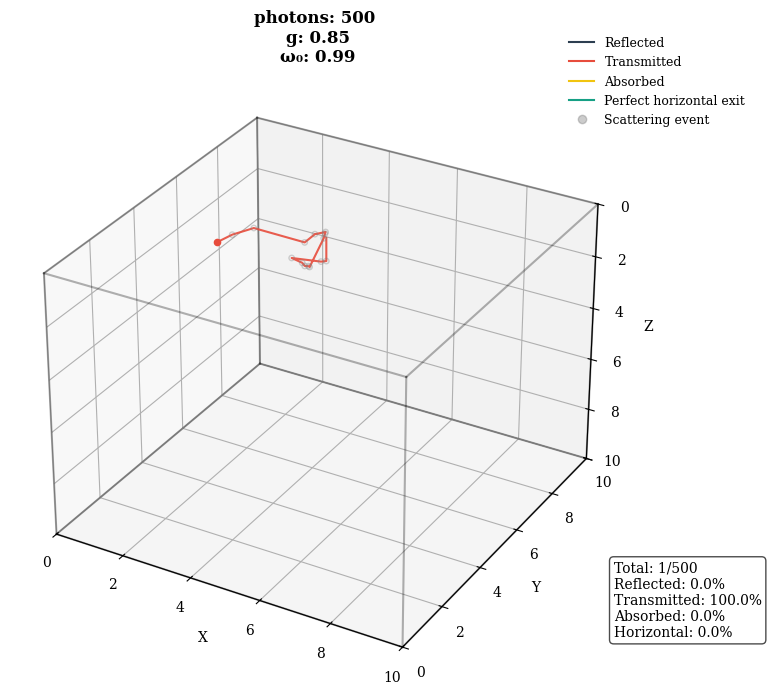

In [8]:
# create photon animation
ani_name = f"animations/cube_animation_photons-{len(all_photon_paths)}_tau-{optical_depth}.mp4"
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# draw cube edges hard coded for animation
cube_edges = [
    [(0, 0, 0), (optical_depth, 0, 0)],
    [(0, 0, 0), (0, optical_depth, 0)],
    [(0, 0, 0), (0, 0, optical_depth)],
    [(optical_depth, 0, 0), (optical_depth, optical_depth, 0)],
    [(optical_depth, 0, 0), (optical_depth, 0, optical_depth)],
    [(0, optical_depth, 0), (optical_depth, optical_depth, 0)],
    [(0, optical_depth, 0), (0, optical_depth, optical_depth)],
    [(0, 0, optical_depth), (optical_depth, 0, optical_depth)],
    [(0, 0, optical_depth), (0, optical_depth, optical_depth)],
    [(optical_depth, optical_depth, 0), (optical_depth, optical_depth, optical_depth)],
    [(optical_depth, 0, optical_depth), (optical_depth, optical_depth, optical_depth)],
    [(0, optical_depth, optical_depth), (optical_depth, optical_depth, optical_depth)]]

print("creating animation...")
anim = FuncAnimation(fig, lambda i: animate(i, shape='cube'), frames=len(all_photon_paths), interval=30, blit=False)
print("saving animation...")
anim.save(ani_name, writer='ffmpeg', fps=10)
print(f"saved {ani_name}")

## Sphere

In [6]:
class sphere:
    def __init__(self, center, radius_sphere):
        self.center = np.array(center)
        self.radius = radius_sphere
    
    def is_inside(self, point):
        point = np.array(point)
        # distance from the center will need to be less than the radius for it to be in the sphere
        distance = np.linalg.norm(point - self.center)
        return distance <= self.radius

In [7]:
class pyramid:
    from scipy.spatial import Delaunay
    def __init__(self, base_height_pyramid=base_height_pyramid, direction="normal"):
        x = np.array([0,0,base_height_pyramid/2,base_height_pyramid,base_height_pyramid]) 
        y = np.array([0,base_height_pyramid,base_height_pyramid/2,0,base_height_pyramid]) 
        z = np.array([0,0,base_height_pyramid,0,0]) 
        
        if direction == "flipped": # flip pyramid upside down
            z = base_height_pyramid - z
        
        self.shape = Delaunay(np.array([x, y, z]).T)
    
    def is_inside(self, point):
        point = np.array(point)
        # use delauney triangulation to see if point inside or outside
        # from old post https://stackoverflow.com/questions/26434726/return-surface-triangle-of-3d-scipy-spatial-delaunay
        boolean = self.shape.find_simplex(point) >= 0
        return boolean == True

## Sphere

In [11]:
def monte_carlo_3D_sphere():
    '''
    single photon simulation in sphere
    '''
    # start at random position on top of shape
    x = radius_sphere #random.uniform(0, optical_depth)
    y = radius_sphere #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]

    # create sphere
    sphere_cloud = sphere([radius_sphere, radius_sphere, radius_sphere], radius_sphere)
    while True:  
        # sample tau
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z

        # has photon hit sphere boundary? 
        if not sphere_cloud.is_inside([newx, newy, newz]):
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A"  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)

In [12]:
# run sphere montecarlo sim
R_array = []  
T_array = [] 
A_array = []  

all_photon_paths = []

# Simulate photons and collect paths
print("Simulating photon paths...")
numR = 0
numT = 0
numA = 0
numS = 0  # Count of photons exiting through sides

for _ in tqdm(range(num_sims)):
    xyz, result = monte_carlo_3D_sphere()
    
    # Record the result
    if result == "R":
        numR += 1
    elif result == "T":
        numT += 1
    elif result == "A":
        numA += 1
    elif result == "S":
        numS += 1
        
    # Store the xyz for visualization
    all_photon_paths.append((xyz, result))

# Calculate fractions
R_fraction = numR/num_sims
T_fraction = numT/num_sims
A_fraction = numA/num_sims
S_fraction = numS/num_sims

print(f"Results for spherical medium with radius {round(radius_sphere, 1)}:")
print(f"Reflection: {R_fraction:.4f}")
print(f"Transmission: {T_fraction:.4f}")
print(f"Absorption: {A_fraction:.4f}")
print(f"Side exit: {S_fraction:.4f}")
print(f"Conservation check: {R_fraction + T_fraction + A_fraction + S_fraction:.4f}")

Simulating photon paths...


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 5535.21it/s]

Results for spherical medium with radius 6.2:
Reflection: 0.3560
Transmission: 0.5240
Absorption: 0.1200
Side exit: 0.0000
Conservation check: 1.0000


creating animation...
saving animation...
saved animations/sphere_animation_photons-500_tau-10.mp4


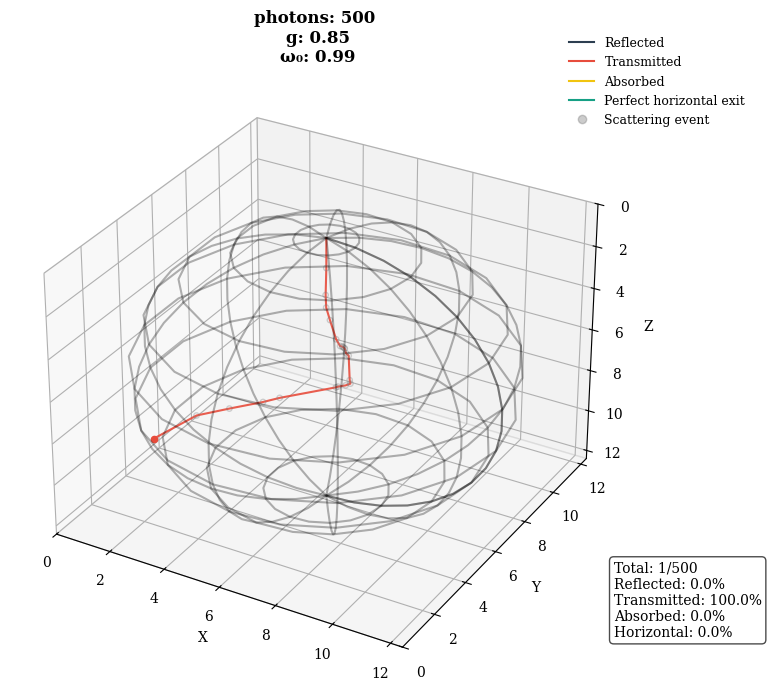

In [13]:
# create photon animation
ani_name = f"animations/sphere_animation_photons-{len(all_photon_paths)}_tau-{optical_depth}.mp4"
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
print("creating animation...")
anim = FuncAnimation(fig, lambda i: animate(i, shape='sphere'), frames=len(all_photon_paths), interval=30, blit=False)
print("saving animation...")
anim.save(ani_name, writer='ffmpeg', fps=10)
print(f"saved {ani_name}")

## Pyramid from top

In [16]:
def monte_carlo_3D_pyramid_top():
    from scipy.spatial import Delaunay
    '''
    single photon simulation in pyramid coming down on the top of the pyramid
    '''
    # start at random position on top of shape
    x = base_height_pyramid/2 #random.uniform(0, optical_depth)
    y = base_height_pyramid/2 #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]

    # create sphere
    pyramid_cloud = pyramid(direction="flipped") # flip so photons go through top first 
    while True:  
        # sample tau"
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z

        # has photon hit sphere boundary? 
        if not pyramid_cloud.is_inside([newx, newy, newz]):
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A"  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)

In [17]:
# run pyramid montecarlo sim
R_array = []  
T_array = [] 
A_array = []  

all_photon_paths = []

# Simulate photons and collect paths
print("Simulating photon paths...")
numR = 0
numT = 0
numA = 0
numS = 0  # Count of photons exiting through sides

for _ in tqdm(range(num_sims)):
    xyz, result = monte_carlo_3D_pyramid_top()
    
    # Record the result
    if result == "R":
        numR += 1
    elif result == "T":
        numT += 1
    elif result == "A":
        numA += 1
    elif result == "S":
        numS += 1
        
    # Store the xyz for visualization
    all_photon_paths.append((xyz, result))

# Calculate fractions
R_fraction = numR/num_sims
T_fraction = numT/num_sims
A_fraction = numA/num_sims
S_fraction = numS/num_sims

print(f"Results for top-down pyramid medium with based & height {round(base_height_pyramid, 1)}:")
print(f"Reflection: {R_fraction:.4f}")
print(f"Transmission: {T_fraction:.4f}")
print(f"Absorption: {A_fraction:.4f}")
print(f"Side exit: {S_fraction:.4f}")
print(f"Conservation check: {R_fraction + T_fraction + A_fraction + S_fraction:.4f}")

Simulating photon paths...


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 5246.64it/s]

Results for top-down pyramid medium with based & height 14.4:
Reflection: 0.2700
Transmission: 0.6620
Absorption: 0.0680
Side exit: 0.0000
Conservation check: 1.0000


creating animation...
saving animation...
saved animations/pyramid_top_animation_photons-500_baseheight-14.0.mp4


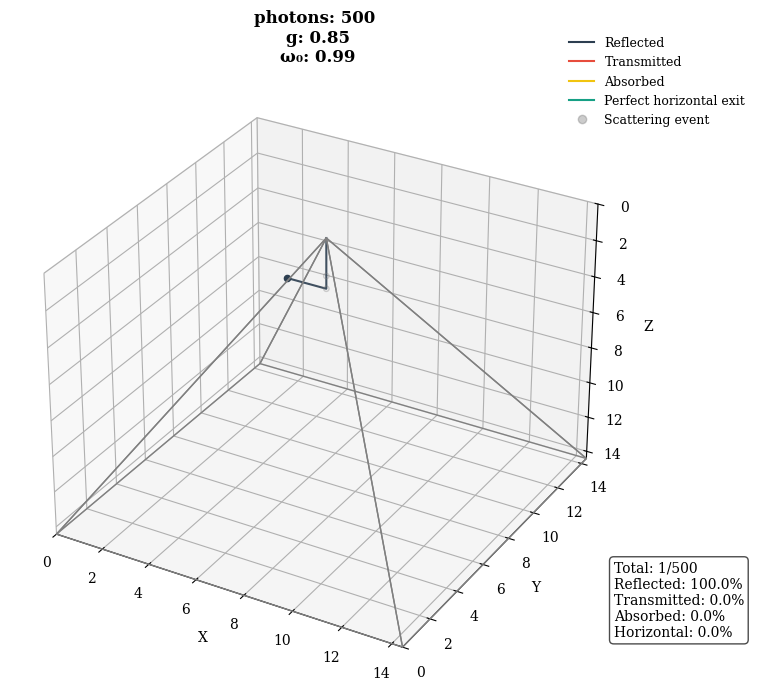

In [18]:
# create photon animation
ani_name = f"animations/pyramid_top_animation_photons-{len(all_photon_paths)}_baseheight-{round(base_height_pyramid, 0)}.mp4"
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
print("creating animation...")
anim = FuncAnimation(fig, lambda i: animate(i, shape='pyramid', shape_flipped="yes"), frames=len(all_photon_paths), interval=30, blit=False)
print("saving animation...")
anim.save(ani_name, writer='ffmpeg', fps=10)
print(f"saved {ani_name}")

## Pyramid from bottom

In [19]:
def monte_carlo_3D_pyramid_bottom():
    from scipy.spatial import Delaunay
    '''
    single photon simulation in pyramid coming up from the base of the pyramid
    '''
    # start at random position on top of shape
    x = base_height_pyramid/2 #random.uniform(0, optical_depth)
    y = base_height_pyramid/2 #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]

    # create sphere
    pyramid_cloud = pyramid(base_height_pyramid)
    while True:  
        # sample tau
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z

        # has photon hit sphere boundary? 
        if not pyramid_cloud.is_inside([newx, newy, newz]):
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A"  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)

In [20]:
# run pyramid montecarlo sim bottom up
R_array = []  
T_array = [] 
A_array = []  

all_photon_paths = []

# Simulate photons and collect paths
print("Simulating photon paths...")
numR = 0
numT = 0
numA = 0
numS = 0  # Count of photons exiting through sides

for _ in tqdm(range(num_sims)):
    xyz, result = monte_carlo_3D_pyramid_bottom()
    
    # Record the result
    if result == "R":
        numR += 1
    elif result == "T":
        numT += 1
    elif result == "A":
        numA += 1
    elif result == "S":
        numS += 1
        
    # Store the xyz for visualization
    all_photon_paths.append((xyz, result))

# Calculate fractions
R_fraction = numR/num_sims
T_fraction = numT/num_sims
A_fraction = numA/num_sims
S_fraction = numS/num_sims

print(f"Results for bottom-up pyramid medium with based & height {round(base_height_pyramid, 1)}:")
print(f"Reflection: {R_fraction:.4f}")
print(f"Transmission: {T_fraction:.4f}")
print(f"Absorption: {A_fraction:.4f}")
print(f"Side exit: {S_fraction:.4f}")
print(f"Conservation check: {R_fraction + T_fraction + A_fraction + S_fraction:.4f}")

Simulating photon paths...


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 6145.61it/s]

Results for bottom-up pyramid medium with based & height 14.4:
Reflection: 0.2980
Transmission: 0.6060
Absorption: 0.0960
Side exit: 0.0000
Conservation check: 1.0000


creating animation...
saving animation...
saved animations/pyramid_bottom_animation_photons-500_baseheight-14.0.mp4


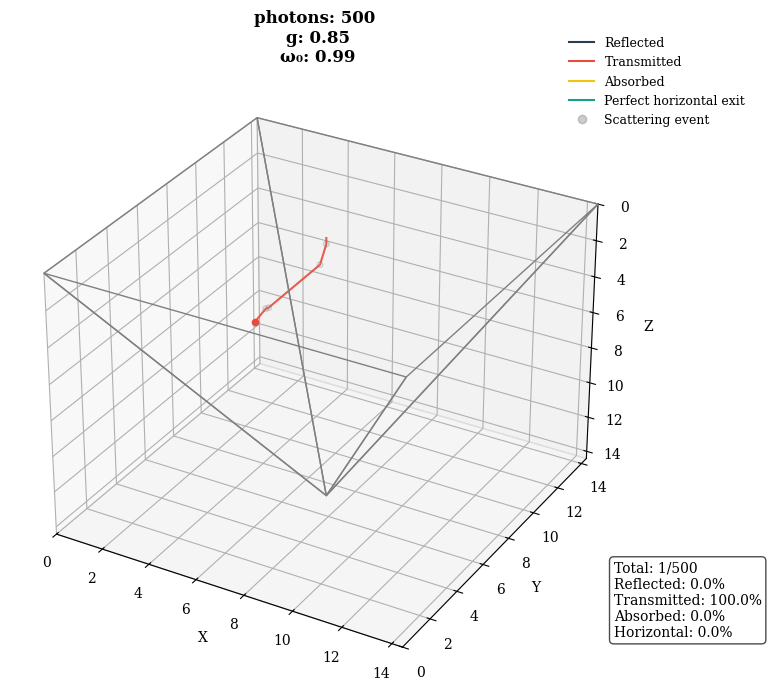

In [21]:
# create photon animation
ani_name = f"animations/pyramid_bottom_animation_photons-{len(all_photon_paths)}_baseheight-{round(base_height_pyramid, 0)}.mp4"
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
print("creating animation...")
anim = FuncAnimation(fig, lambda i: animate(i, shape='pyramid'), frames=len(all_photon_paths), interval=30, blit=False)
print("saving animation...")
anim.save(ani_name, writer='ffmpeg', fps=10)
print(f"saved {ani_name}")

## ~ scrap paper ~

In [ ]:
# https://stackoverflow.com/questions/29311682/finding-if-point-is-in-3d-poly-in-python
# if point is inside polygon
# Delaunay(poly).find_simplex(point) >= 0  # True if point lies within poly
# point is numpy array [x, y, z]
# poly is N x,y,z coords e.g. np.random.rand(65, 3)

In [ ]:
# from old post https://stackoverflow.com/questions/26434726/return-surface-triangle-of-3d-scipy-spatial-delaunay
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from scipy.spatial import Delaunay

# u, v are parameterisation variables
optical_depth = base_height_pyramid
u = np.array([0,0,optical_depth/2,optical_depth,optical_depth]) 
v = np.array([0,optical_depth,optical_depth/2,0,optical_depth]) 
w = np.array([0,0,optical_depth,0,0]) 

x = u
y = v
z = w

# Triangulate parameter space to determine the triangles
#tri = mtri.Triangulation(u, v)
pyramid = Delaunay(np.array([u,v, w]).T)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# The triangles in parameter space determine which x, y, z points are
# connected by an edge
#ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
#ax.plot_trisurf(x, y, z, triangles=pyramid.simplices, cmap=plt.cm.Spectral)
ax.plot_trisurf(x, y, z, triangles=pyramid.simplices, color='none', edgecolor='black', linewidth=1.0)


plt.show()

In [ ]:
pyramid = Delaunay(np.array([u,v,w]).T)
pyramid.find_simplex([10, 0.2, 0.1]) >= 0

In [ ]:
# flip it 
# u, v are parameterisation variables
optical_depth = base_height_pyramid
x = np.array([0, 0, base_height_pyramid/2, base_height_pyramid, base_height_pyramid]) 
y = np.array([0, base_height_pyramid, base_height_pyramid/2, 0, base_height_pyramid]) 
z = np.array([0, 0, base_height_pyramid, 0, 0])

z = base_height_pyramid - z

# Triangulate parameter space to determine the triangles
#tri = mtri.Triangulation(u, v)
pyramid = Delaunay(np.array([u,v, w]).T)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# The triangles in parameter space determine which x, y, z points are
# connected by an edge
#ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
#ax.plot_trisurf(x, y, z, triangles=pyramid.simplices, cmap=plt.cm.Spectral)
ax.plot_trisurf(x, y, z, triangles=pyramid.simplices, color='none', edgecolor='black', linewidth=1.0)


plt.show()